# Custom kernel implementation

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.datasets import load_iris
from sklearn import svm
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [52]:
# load toy dataset, 2 classes (50 samples each), 2 features
data = load_iris()
X = data.data
Y = data.target
X = data.data[Y != 2]
Y = data.target[Y != 2]


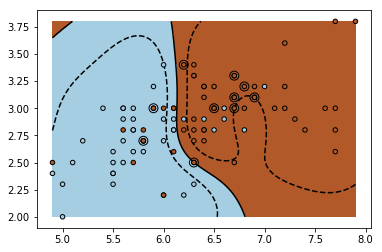

In [3]:
# Basic SVM example
n_sample = len(X)

# uncomment to make random order
#order = np.random.permutation(n_sample)
#X = X[order]
#Y = Y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
Y_train = Y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
Y_test = Y[int(.9 * n_sample):]

clf = svm.SVC(kernel="rbf", gamma=4); # linear, rbf, poly
clf.fit(X_train, Y_train);

# plot
plt.figure()
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10, edgecolor='k')

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

# plt.show()


## 2.2 random walk kernel and 2.3 kernel induced by a clustered representation

In [47]:
def rbf_kernel(X, sigma, diag=0):
    N = X.shape[0]
    K = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            if i == j:
                K[i,j] = diag
            else:
                x_i = X[i, :].reshape(1,-1)
                x_j = X[j, :].reshape(1,-1)

                K[i, j] = np.exp(-cdist(x_i, x_j, 'sqeuclidean') / (sigma ** 2)) # euclidean?
    return K


def make_D_matrix(K):
    K_sum = np.sum(K, axis=1)
    D = np.diag(K_sum)

    return D


def make_L_matrix(K, D):
    D_temp = np.diag( np.diag(D) ** -0.5 )
    L = D_temp @ K @ D_temp
    
    w, v = LA.eig(L) # w = eigenvalues, v = normalized (unit “length”) eigenvectors
    
    #print("w: {}".format(w))
    #print("v: {}".format(v))
    
    return L

def step_transfer(L, lambda_cut):
    w, v = LA.eig(L) # w = eigenvalues
    return np.where(w > lambda_cut, 1, 0)

def apply_transfer_func(L, D, K, type="linear"):
    if type == "linear":
        return L, D, K
    if type == "step":
        None
        
    L_hat = 0
    D_hat = 0
    K_hat = 0
    
    return L_hat, D_hat, K_hat


def test_run(X):
    X = X[:3, :] # "testing with a small X"
    
    K = rbf_kernel(X, 1)
    D = make_D_matrix(K)
    L = make_L_matrix(K, D)
    
    L, D, K = apply_transfer_func(L, D, K)
    
    # print(K, "\n\n", D, "\n\n", L)    



test_run(X)   

In [53]:
# Basic SVM with predefined kernel matrix

def accuracy(t, y):
    val = 0.0
    N = len(t)
    for i in range(N):
        if t[i] == y[i]:
            val += 1
    
    return val / N


def test_svm(X, Y):
    # Shuffle data
    np.random.seed(40)
    order = np.random.permutation(n_sample)
    X = X[order]
    Y = Y[order].astype(np.float)
    
    # Make Kernel
    K = rbf_kernel(X, 1)
    D = make_D_matrix(K)
    L = make_L_matrix(K, D)
    
    L, D, K = apply_transfer_func(L, D, K)
    
    # Remove data without labels
    K_red = K[:70,:70]
    Y_red = Y[:70]
    
    K_test = K[70:100,:70]
    
    print(K_red.shape)
    
    # Apply to SVM
    clf = svm.SVC(kernel="precomputed", C=1)
    clf.fit(K_red, Y_red)
    
    # Predict and accuracy
    y_pred = clf.predict(K_test)
    
    #print('t', Y[70:100])
    #print('y', y_pred)
    print("accuracy:", accuracy(y_pred, Y[70:100]))
    
    
    # Basic SVM
    clf2 = svm.SVC(kernel="linear", C=1)
    clf2.fit(X[:70], Y_red)
    
    y_pred2 = clf2.predict(X[70:100])
    print("accuracy:", accuracy(y_pred2, Y[70:100]))

    
test_svm(X, Y)


(70, 70)
accuracy: 1.0
accuracy: 1.0


In [ ]:
# Do transformation according to all data points
# Sort out only the labeled points and use them to train a linear SVM

    
        
        
def transformation(X):
    
    K = rbf_kernel(X, 1)
    D = make_D_matrix(K)
    L = make_L_matrix(K, D)
    
    L, D, K = apply_transfer_func(L, D, K)
    w, v = LA.eig(L)
    
    return v



# Basic SVM example
n_sample = len(X)

# uncomment to make random order
#order = np.random.permutation(n_sample)
#X = X[order]
#Y = Y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
Y_train = Y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
Y_test = Y[int(.9 * n_sample):]

V = transformation(X)
V_train = V[:int(.9 * n_sample)]
# print(V_train.shape)
